In [1]:
# @title Install (if needed) and import libraries
# Colab usually has these preinstalled; uncomment if required.
# !pip install scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# @title Load Adult Income dataset from OpenML
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# @title Basic cleaning and encoding
# Target: income (<=50K, >50K)
df["income"] = (df["class"] == ">50K").astype(int)
df.drop(columns=["class"], inplace=True)

# Protected attribute: 'sex'
df["sex"] = (df["sex"] == "Male").astype(int)  # 1 = Male, 0 = Female

# Drop rows with missing values
df = df.replace("?", np.nan).dropna().reset_index(drop=True)

# Split features/target
y = df["income"].values
X = df.drop(columns=["income"])

# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']


In [4]:
# @title One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

protected_col = "sex"  # keep track of protected attribute
X_encoded.head()


,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,1,0,0,40,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,38,89814,9,1,0,0,50,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,28,336951,12,1,0,0,40,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,44,160323,10,1,7688,0,40,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,34,198693,6,1,0,0,30,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [5]:
# @title Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

# Also keep protected-attribute column for analysis
sex_test = X_test[protected_col].values  # 1 = Male, 0 = Female


In [6]:
# @title Fairness metric helpers

def group_positive_rate(y_pred, group_mask):
    """
    Returns the fraction of positive predictions in a given group.
    group_mask: boolean or 0/1 array; True/1 means member of the group.
    """
    return y_pred[group_mask == 1].mean()

def print_fairness_report(y_true, y_pred, protected_attr, label_pos=1):
    """
    Prints accuracy and simple fairness statistics:
    - Positive prediction rate for each group
    - Difference in positive rate
    """
    acc = accuracy_score(y_true, y_pred)
    male_mask = (protected_attr == 1)
    female_mask = (protected_attr == 0)

    rate_male = group_positive_rate(y_pred, male_mask)
    rate_female = group_positive_rate(y_pred, female_mask)
    diff = rate_male - rate_female

    print("Overall Accuracy: {:.3f}".format(acc))
    print("Positive rate (Male):   {:.3f}".format(rate_male))
    print("Positive rate (Female): {:.3f}".format(rate_female))
    print("Difference (Male - Female): {:.3f}".format(diff))


In [7]:
# @title Baseline logistic regression *with* protected attribute

scaler_baseline = StandardScaler(with_mean=False)  # sparse-safe
X_train_scaled = scaler_baseline.fit_transform(X_train)
X_test_scaled = scaler_baseline.transform(X_test)

baseline_clf = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
baseline_clf.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_clf.predict(X_test_scaled)

print("=== BASELINE MODEL (WITH 'sex' FEATURE) ===")
print_fairness_report(y_test, y_pred_baseline, sex_test)


=== BASELINE MODEL (WITH 'sex' FEATURE) ===
Overall Accuracy: 0.844
Positive rate (Male):   0.260
Positive rate (Female): 0.080
Difference (Male - Female): 0.180


In [8]:
# @title Bias-aware model *without* the protected attribute

# Drop the protected attribute from training data
X_train_fair = X_train.drop(columns=[protected_col])
X_test_fair = X_test.drop(columns=[protected_col])

scaler_fair = StandardScaler(with_mean=False)
X_train_fair_scaled = scaler_fair.fit_transform(X_train_fair)
X_test_fair_scaled = scaler_fair.transform(X_test_fair)

fair_clf = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
fair_clf.fit(X_train_fair_scaled, y_train)

y_pred_fair = fair_clf.predict(X_test_fair_scaled)

print("=== FAIRNESS-AWARE MODEL (WITHOUT 'sex') ===")
print_fairness_report(y_test, y_pred_fair, sex_test)


=== FAIRNESS-AWARE MODEL (WITHOUT 'sex') ===
Overall Accuracy: 0.844
Positive rate (Male):   0.257
Positive rate (Female): 0.083
Difference (Male - Female): 0.174


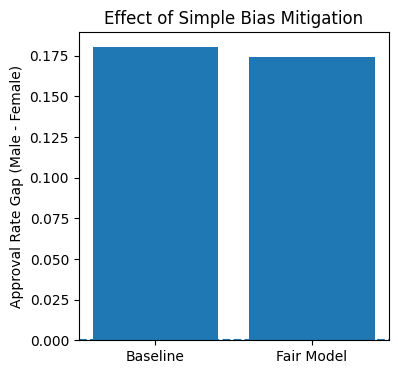

In [9]:
# @title Compare fairness gap visually

# Compute approval gaps (Male - Female) for both models
def approval_gap(y_pred, protected_attr):
    male_mask = (protected_attr == 1)
    female_mask = (protected_attr == 0)
    return group_positive_rate(y_pred, male_mask) - group_positive_rate(y_pred, female_mask)

gap_baseline = approval_gap(y_pred_baseline, sex_test)
gap_fair = approval_gap(y_pred_fair, sex_test)

plt.figure(figsize=(4, 4))
plt.bar(["Baseline", "Fair Model"], [gap_baseline, gap_fair])
plt.axhline(0, linestyle="--")
plt.ylabel("Approval Rate Gap (Male - Female)")
plt.title("Effect of Simple Bias Mitigation")
plt.show()


In [16]:
# Programmatic download of the current notebook is not directly supported.
# Please use the Colab UI: File > Download > Download .ipynb

In [14]:
from google.colab import drive
drive.mount('/content/drive')

# The previous 'cp' command was causing an error and is removed.
# If you wish to save a specific file to Drive, you can do so by explicitly saving it first.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
